# Braindecode Tutorial: Basic Training with MNE Epochs

This tutorial demonstrates how to train neural network models from the Braindecode library on EEG data formatted as MNE epochs.

**Tutorial based on:** https://braindecode.org/dev/auto_examples/model_building/plot_basic_training_epochs.html

## Overview

You will learn how to:
- Find and examine available EEG models in Braindecode
- Understand model parameters and requirements
- Load and prepare EEG data with MNE
- Train models using scikit-learn compatible workflows

## 1. Setup and Imports

In [21]:
# Import necessary libraries
import numpy as np
import mne
from braindecode import EEGClassifier
from braindecode.models import ShallowFBCSPNet
from braindecode.models.util import models_dict

# Set random seed for reproducibility
np.random.seed(42)

## 2. Exploring Available Models

Braindecode provides numerous EEG-specific architectures. Let's explore what's available:

In [22]:
# Display all available models in braindecode
print("Available models in Braindecode:")
print("="*50)
for model_name in sorted(models_dict.keys()):
    print(f"  - {model_name}")

Available models in Braindecode:
  - ATCNet
  - AttentionBaseNet
  - AttnSleep
  - BDTCN
  - BIOT
  - CTNet
  - ContraWR
  - Deep4Net
  - DeepSleepNet
  - EEGConformer
  - EEGITNet
  - EEGInceptionERP
  - EEGInceptionMI
  - EEGMiner
  - EEGNeX
  - EEGNet
  - EEGSimpleConv
  - EEGTCNet
  - FBCNet
  - FBLightConvNet
  - FBMSNet
  - IFNet
  - Labram
  - MSVTNet
  - SCCNet
  - SPARCNet
  - ShallowFBCSPNet
  - SignalJEPA
  - SignalJEPA_Contextual
  - SignalJEPA_PostLocal
  - SignalJEPA_PreLocal
  - SincShallowNet
  - SleepStagerBlanco2020
  - SleepStagerChambon2018
  - SyncNet
  - TIDNet
  - TSception
  - USleep


### Understanding Model Parameters

For this tutorial, we'll use **ShallowFBCSPNet** from Schirrmeister et al. 2017.
Let's examine its required parameters:

In [23]:
# Display ShallowFBCSPNet documentation
help(ShallowFBCSPNet.__init__)

**Key parameters to note:**
- `n_chans`: Number of EEG channels
- `n_times`: Number of time points per epoch
- `n_outputs`: Number of output classes
- `sfreq`: Sampling frequency (optional)
- `chs_info`: Channel information (optional)

## 3. Creating Synthetic EEG Data with MNE

We'll create synthetic data to demonstrate the workflow:

In [24]:
# Parameters for synthetic data
n_epochs = 100
n_channels = 3
n_times = 1024
sfreq = 256  # Sampling frequency in Hz
n_classes = 4

# Generate random EEG data
data = np.random.randn(n_epochs, n_channels, n_times)

# Generate random labels (0 to n_classes-1)
labels = np.random.randint(0, n_classes, size=n_epochs)

# Create channel names
ch_names = [f'EEG_{i+1}' for i in range(n_channels)]

# Create MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create MNE EpochsArray
epochs = mne.EpochsArray(data, info)

print(f"Created epochs with shape: {epochs.get_data().shape}")
print(f"Labels: {labels[:10]}...")  # Show first 10 labels

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Created epochs with shape: (100, 3, 1024)
Labels: [1 0 3 2 3 0 1 1 1 1]...


### Visualize the Data

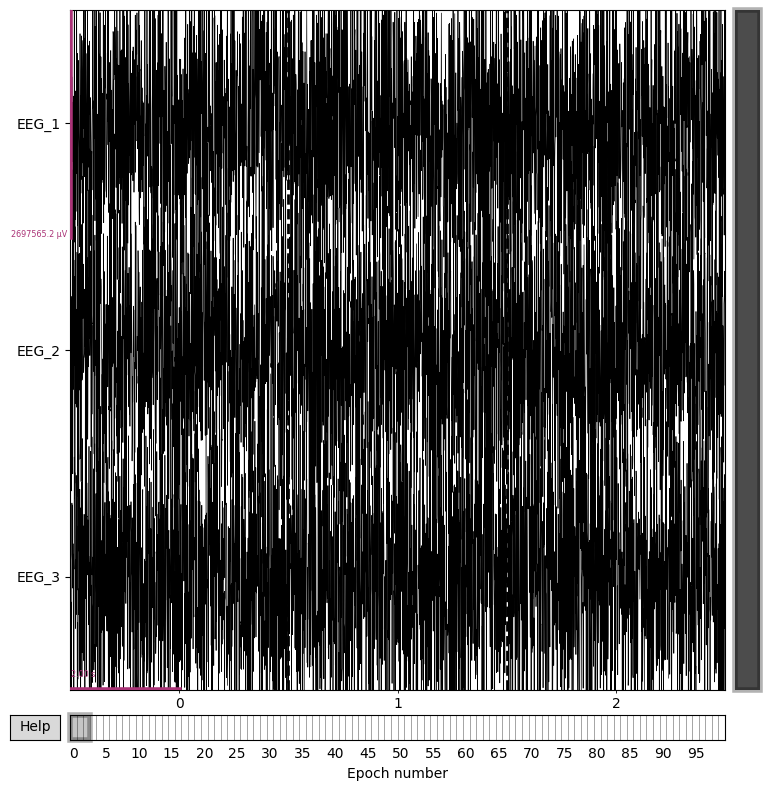

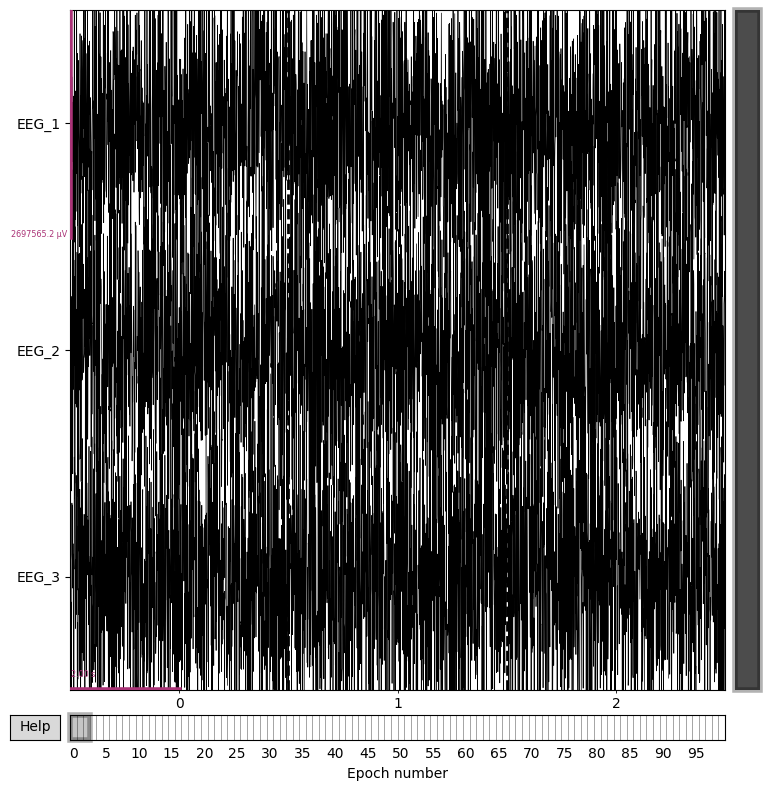

In [25]:
# Plot a few epochs to visualize the data
epochs.plot(n_epochs=3, n_channels=n_channels, scalings='auto')

## 4. Training with EEGClassifier (Scikit-Learn Wrapper)

Braindecode wraps PyTorch models through `skorch`, providing scikit-learn compatibility.

In [26]:
# Create the classifier
# Note: Signal-related parameters (n_chans, n_times, n_outputs, sfreq, chs_info) 
# are automatically inferred from training data!

from skorch.dataset import ValidSplit

clf = EEGClassifier(
    module=ShallowFBCSPNet,
    # You can also use string name: module='ShallowFBCSPNet',
    
    # Model-specific parameters use 'module__' prefix
    # module__n_chans=n_channels,  # Auto-inferred!
    # module__n_times=n_times,      # Auto-inferred!
    # module__n_outputs=n_classes,  # Auto-inferred!
    
    # Training parameters
    max_epochs=20,
    optimizer__lr=0.001,  # Use optimizer__ prefix for optimizer parameters
    batch_size=32,
    train_split=ValidSplit(0.2),  # Use ValidSplit object for validation split
    device='cpu',  # Use 'cuda' if GPU is available
    
    # Verbosity
    verbose=1,
)

print("EEGClassifier created successfully!")

EEGClassifier created successfully!


### Train the Model

**Understanding the Training Process:**

When you call `clf.fit(X, y)`, here's what happens:

1. **Data Splitting**: The data is split into training (80%) and validation (20%) sets based on `train_split=ValidSplit(0.2)`
   - Training set: Used to update model weights
   - Validation set: Used to evaluate performance on unseen data during training

2. **Epoch Loop**: The model trains for `max_epochs=20` iterations
   - Each epoch processes all training data in batches of size 32
   - After each epoch, the model evaluates on the validation set

3. **Forward & Backward Pass**:
   - **Forward**: Input EEG data flows through the neural network layers
   - **Loss Calculation**: Compare predictions to true labels
   - **Backward**: Gradients are computed (backpropagation)
   - **Optimization**: Weights are updated using Adam optimizer with learning rate 0.001

**Understanding the Output Metrics:**

- **epoch**: Current training iteration (1-20)
- **train_loss**: Average loss on training data
  - Lower is better (indicates model is learning patterns)
  - Cyan color highlights show when it improves (decreases)
  
- **valid_acc**: Accuracy on validation data (0.0 to 1.0)
  - Percentage of correctly classified validation samples
  - Green color highlights show when it improves (increases)
  - In this example: 0.2000 = 20% accuracy (random guessing for 4 classes would be 25%)
  
- **valid_loss**: Average loss on validation data
  - Lower is better (indicates better generalization)
  - Purple/magenta color highlights show when it improves (decreases)
  - Should decrease over epochs if model is learning
  
- **dur**: Duration of the epoch in seconds
  - Time taken to complete one full epoch of training

**What to Look For:**
- ✅ Train loss should decrease over time
- ✅ Valid loss should decrease (model generalizing well)
- ⚠️ If valid_loss increases while train_loss decreases = overfitting
- ✅ Valid accuracy should increase over time

In [34]:
# Extract data and labels for training
X = epochs.get_data()
y = labels

# Train the model
print("Starting training...")
clf.fit(X, y)
print("\nTraining completed!")

print("\n" + "="*70)
print("TRAINING RESULTS ANALYSIS")
print("="*70)

# Analyze the training
initial_train_loss = clf.history[0]['train_loss']
final_train_loss = clf.history[-1]['train_loss']
initial_valid_loss = clf.history[0]['valid_loss']
final_valid_loss = clf.history[-1]['valid_loss']
best_valid_acc = max([h['valid_acc'] for h in clf.history])

print(f"\n📊 Loss Analysis:")
print(f"   Training Loss:   {initial_train_loss:.4f} → {final_train_loss:.4f} (change: {final_train_loss - initial_train_loss:.4f})")
print(f"   Validation Loss: {initial_valid_loss:.4f} → {final_valid_loss:.4f} (change: {final_valid_loss - initial_valid_loss:.4f})")

print(f"\n🎯 Accuracy:")
print(f"   Best Validation Accuracy: {best_valid_acc:.2%}")
print(f"   Random Baseline (4 classes): 25.00%")

print(f"\n⏱️  Training Speed:")
total_time = sum([h['dur'] for h in clf.history])
print(f"   Total training time: {total_time:.2f} seconds")
print(f"   Average per epoch: {total_time/len(clf.history):.4f} seconds")

print("\n💡 Interpretation:")
if final_valid_loss < initial_valid_loss:
    print("   ✅ Model is learning - validation loss decreased")
else:
    print("   ⚠️  Model may not be learning well - validation loss increased")
    
if best_valid_acc > 0.25:
    print("   ✅ Model performs better than random guessing")
else:
    print("   ⚠️  Model is performing at or below random chance")
    print("      (This is expected with random synthetic data!)")
print("="*70)

Starting training...
Re-initializing module because the following parameters were re-set: n_chans, n_outputs, n_times.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4336       0.1000        1.9367  0.0206
      2        1.3923       0.1000        1.8925  0.0205
      3        1.3966       0.1000        1.8398  0.0185
      4        1.4463       0.1000        1.7912  0.0183
      5        1.4442       0.1000        1.7467  0.0202
      6        1.3808       0.1000        1.7135  0.0183
      7        1.3900       0.1000        1.6780  0.0196
      8        1.4019       0.1000        1.6472  0.0177
      9        1.3789       0.1000        1.6155  0.0198
     10        1.4429       0.1000        1.5877  0.0186
     11        1.3522       0.1000        1.5658  0.0193
     12        1.4277       0.1000        1.5440  0.0186
     13        1.4100       0

## 5. Evaluate the Model

In [35]:
# Get training accuracy
train_score = clf.score(X, y)
print(f"Training accuracy: {train_score:.4f}")

Training accuracy: 0.3200


In [36]:
# Make predictions on a few samples
predictions = clf.predict(X[:10])
print("\nPredictions for first 10 samples:")
print(f"Predicted: {predictions}")
print(f"Actual:    {y[:10]}")


Predictions for first 10 samples:
Predicted: [1 1 3 1 2 1 1 1 1 1]
Actual:    [1 0 3 2 3 0 1 1 1 1]


## 6. Accessing Training History

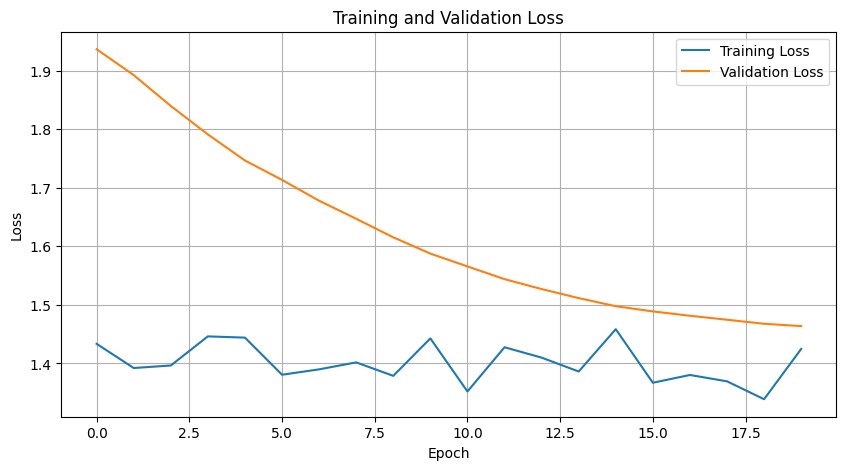

In [37]:
# Plot training and validation loss
import matplotlib.pyplot as plt

history = clf.history

# Extract losses
train_loss = [h['train_loss'] for h in history]
valid_loss = [h['valid_loss'] for h in history]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 7. Using Different Models

Let's try another model from the Braindecode library:

In [ ]:
# Try EEGNetv4
from braindecode.models import EEGNet
from skorch.dataset import ValidSplit

clf_eegnet = EEGClassifier(
    module=EEGNet,
    max_epochs=20,
    optimizer__lr=0.001,  # Use optimizer__ prefix for optimizer parameters
    batch_size=32,
    train_split=ValidSplit(0.2),  # Use ValidSplit object for validation split
    device='cpu',
    verbose=1,
)

# Train
print("Training EEGNet...")
clf_eegnet.fit(X, y)

# Evaluate
eegnet_score = clf_eegnet.score(X, y)
print(f"\nEEGNet Training accuracy: {eegnet_score:.4f}")

Training EEGNetv4...
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.4262       0.2000        1.3870  0.5105
      2        1.3954       0.2000        1.3869  0.4960
      3        1.4143       0.3000        1.3868  0.4963
      4        1.3681       0.3000        1.3867  0.4909
      5        1.3872       0.3000        1.3867  0.4919
      6        1.3624       0.3000        1.3866  0.4957
      7        1.3938       0.2500        1.3865  0.4942
      8        1.3987       0.2000        1.3864  0.5000
      9        1.3923       0.3000        1.3863  0.4963
     10        1.3857       0.2500        1.3862  0.4947
     11        1.3909       0.2500        1.3862  0.4951
     12        1.3738       0.2500        1.3861  0.4944
     13        1.4041       0.2500        1.3860  0.4920
     14        1.3883       0.2500        1.3860  0.5026
     15        1.3754       0.2500        1.3859  0.5152
     16   

## 8. Working with Real EEG Data

Here's a template for loading your own EEG data:

In [40]:
# Example: Loading real EEG data
# Uncomment and modify based on your data format

# Option 1: From MNE-compatible file formats (.fif, .edf, .bdf, etc.)
# raw = mne.io.read_raw_fif('your_data.fif', preload=True)
# events = mne.find_events(raw)
# epochs = mne.Epochs(raw, events, event_id={'class1': 1, 'class2': 2}, 
#                     tmin=-0.5, tmax=2.0, baseline=None, preload=True)

# Option 2: From numpy arrays
# data = np.load('your_data.npy')  # Shape: (n_epochs, n_channels, n_times)
# labels = np.load('your_labels.npy')  # Shape: (n_epochs,)
# info = mne.create_info(ch_names=your_channel_names, sfreq=your_sfreq, ch_types='eeg')
# epochs = mne.EpochsArray(data, info)

print("Template provided above for loading real data.")

Template provided above for loading real data.


## Summary

In this tutorial, you learned:

1. How to explore available models in Braindecode using `models_dict`
2. How to create and prepare EEG data with MNE
3. How to use `EEGClassifier` wrapper for scikit-learn-compatible training
4. How automatic parameter inference simplifies the workflow
5. How to train, evaluate, and visualize model performance

## Next Steps

- Try different models from Braindecode
- Experiment with hyperparameters (learning rate, batch size, etc.)
- Apply preprocessing techniques to improve performance
- Use cross-validation for more robust evaluation
- Load and train on real EEG datasets

## References

- Braindecode documentation: https://braindecode.org/
- Schirrmeister et al. (2017): Deep learning with convolutional neural networks for EEG decoding and visualization
- MNE-Python: https://mne.tools/